#   EDA
## 1. Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_countries = pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2')[2]
df_countries = df_countries[['Code', 'Country name (using title case)']]
df_countries.rename(columns={'Code':'Country','Country name (using title case)':'Country name'},inplace=True)
df_countries.to_csv ('../Data/countries.csv', index = False, header=True)
df_countries = pd.read_csv('../data/countries.csv')
print(df_countries.info())


df_2020Q1 = pd.read_csv('D:/Data Camp/Data/2020Q1.csv', skiprows = 4)
df_2020Q2 = pd.read_csv('D:/Data Camp/Data/2020Q2.csv', skiprows = 4)
df_2020Q3 = pd.read_csv('D:/Data Camp/Data/2020Q3.csv', skiprows = 4)
df_2020Q4 = pd.read_csv('D:/Data Camp/Data/2020Q4.csv', skiprows = 4)

df_2020 = pd.concat([df_2020Q1, df_2020Q2, df_2020Q3, df_2020Q4])


df_2019Q1 = pd.read_csv('D:/Data Camp/Data/2019Q1.csv', skiprows = 4)
df_2019Q2 = pd.read_csv('D:/Data Camp/Data/2019Q2.csv', skiprows = 4)
df_2019Q3 = pd.read_csv('D:/Data Camp/Data/2019Q3.csv', skiprows = 4)
df_2019Q4 = pd.read_csv('D:/Data Camp/Data/2019Q4.csv', skiprows = 4)
df_2019 = pd.concat([df_2019Q1, df_2019Q2, df_2019Q3, df_2019Q4])


df_all = pd.concat([df_2020, df_2019])

df_all['Date'] = pd.to_datetime(df_all['Date'])


df = pd.merge(df_all,df_countries, on='Country')
df = df[['Date', 'City', 'Specie', 'max', 'min', 'median', 'Country name']]
df.info()
df.head()

df_lockdown_dates = pd.read_csv('D:/Data Camp/Data/country_lockdown_dates.csv', engine='python')
df_lockdown_datesJHUMatch = pd.read_csv('D:/Data Camp/Data/countryLockdowndatesJHUMatch.csv', engine='python')
df_lockdown_dates_full = pd.concat([df_lockdown_dates, df_lockdown_datesJHUMatch])
df_lockdown_dates_full['Date'] = pd.to_datetime(df_lockdown_dates_full['Date'])

df_lockdown_dates_full.rename(columns={'Country/Region':'Country name'},inplace=True)
df_lockdown_dates_full = df_lockdown_dates_full[['Country name','Date']]
df_lockdown_dates_full.rename(columns={'Date':'Starting Date'},inplace=True)
df_lockdown_dates_full.tail()
df_final = pd.merge(df, df_lockdown_dates_full, on='Country name')
df_final.head()

df_o3 = df_final[df_final['Specie'] == 'o3']
df_o3 = df_o3.set_index("Date")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country       248 non-null    object
 1   Country name  249 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4495514 entries, 0 to 4495513
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Date          datetime64[ns]
 1   City          object        
 2   Specie        object        
 3   max           float64       
 4   min           float64       
 5   median        float64       
 6   Country name  object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 274.4+ MB


In [2]:
def shutdownData(df, country, shutdown_date, reopen_date):

    mask = ((pd.Series(map(lambda x: x.month <= shutdown_date[0], df.index.date), index=df.index)) &
                                                ((pd.Series(map(lambda x: x.day < shutdown_date[1], df.index.date), index=df.index))))
    #first get dates after the start date for all years
    shutdown_time_period_df = df.loc[~mask, :]

    #remove the later months
    shutdown_time_period_df = shutdown_time_period_df.loc[shutdown_time_period_df.index.month<=reopen_date[0]]

    #now get dates before the end date
    mask2 = ((pd.Series(map(lambda x: x.month == reopen_date[0], shutdown_time_period_df.index.date), index=shutdown_time_period_df.index)) &
                                                ((pd.Series(map(lambda x: x.day >= reopen_date[1], shutdown_time_period_df.index.date), index=shutdown_time_period_df.index))))

    shutdown_time_period_df = shutdown_time_period_df.loc[~mask2, :]

    shutdown_time_period_df = shutdown_time_period_df.loc[shutdown_time_period_df["Country name"] == country]
    
    return shutdown_time_period_df

In [3]:
india_o3_shutdown_df = shutdownData(df_o3, "India", (3, 24), (8, 18))
india_o3_shutdown_df

,City,Specie,max,min,median,Country name,Starting Date
Date,,,,,,,
2020-01-30,Thrissur,o3,20.8,2.6,9.7,India,2020-03-24
2020-01-31,Thrissur,o3,23.2,2.7,12.7,India,2020-03-24
2020-01-27,Thrissur,o3,37.3,2.9,8.5,India,2020-03-24
2020-02-24,Thrissur,o3,36.6,2.7,12.5,India,2020-03-24
2020-02-29,Thrissur,o3,32.6,2.9,13.4,India,2020-03-24
...,...,...,...,...,...,...,...
2019-07-29,Kolkata,o3,21.6,5.2,10.5,India,2020-03-24
2019-08-05,Kolkata,o3,26.2,1.5,7.8,India,2020-03-24
2019-08-16,Kolkata,o3,31.6,2.9,8.3,India,2020-03-24


In [4]:
bar_plot_info = india_o3_shutdown_df.groupby(india_o3_shutdown_df.index.year).mean()
bar_plot_info

,max,min,median
Date,,,
2019,41.849690,4.212629,13.858362
2020,50.766976,2.926133,11.775855


In [5]:
Attributes =list(bar_plot_info)
AttNo = len(Attributes)

In [6]:
values = bar_plot_info.iloc[1].tolist()
values += values [:1]
values

[50.766975881261466, 2.926133050622868, 11.775854757487382, 50.766975881261466]

In [7]:
angles = [n / float(AttNo) * 2 * 3.14 for n in range(AttNo)]
angles += angles [:1]

In [8]:
values2 = bar_plot_info.iloc[0].tolist()
values2 += values2 [:1]

angles2 = [n / float(AttNo) * 2 * 3.14 for n in range(AttNo)]
angles2 += angles2 [:1]

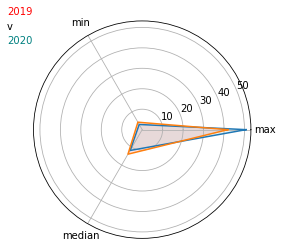

In [9]:
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1],Attributes)

ax.plot(angles,values)
ax.fill(angles, values, 'teal', alpha=0.1)

ax.plot(angles2,values2)
ax.fill(angles2, values2, 'red', alpha=0.1)

#Rather than use a title, individual text points are added
plt.figtext(0.2,0.9,"2019",color="red")
plt.figtext(0.2,0.85,"v")
plt.figtext(0.2,0.8,"2020",color="teal")
plt.show()

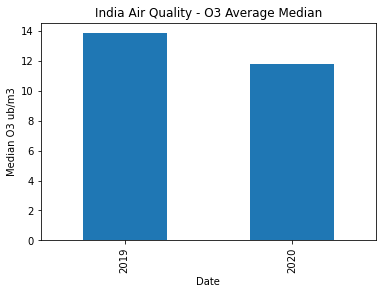

In [10]:
bar_plot_info.plot(kind="bar", y="median", legend=None)
plt.ylabel("Median O3 ub/m3")
plt.title("India Air Quality - O3 Average Median")
plt.savefig("D:/Data Camp/Data/Mumbai/India_O3median.png")

In [11]:
#get percentage decrease year over year
bar_plot_info.pct_change()


,max,min,median
Date,,,
2019,NaN,NaN,NaN
2020,0.213079,-0.30539,-0.150271


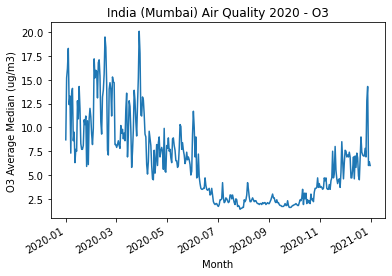

In [12]:
IN_2020_o3_df = df_o3.loc[(df_o3.index.year == 2020) & (df_o3["City"] == "Mumbai")]
IN_line_axes = IN_2020_o3_df.plot(kind="line", y="median", legend=None)
#set titles, axes labels
IN_line_axes.set_title("India (Mumbai) Air Quality 2020 - O3")
IN_line_axes.set_ylabel("O3 Average Median (ug/m3)")
IN_line_axes.set_xlabel("Month")

IN_line_axes.get_figure().savefig("D:/Data Camp/Data/Mumbai/In_O3_2020_line_plot.png")